## <span style="color:blue"> SwissMetNet Historical Data </span>

final selected time period: 2019.07 - 2022.11

### <b style="color:blue;"> Data sources </b>

SwissMetNet is the automatic monitoring network of MeteoSwiss. Current measurement values are available on [opendata.swiss](https://opendata.swiss/de/dataset/automatische-wetterstationen-aktuelle-messwerte), historical data is not.

Collection of APIs and data stored in a DB relating to the SwissMetNet data is available on [ExistenzAPI](https://api.existenz.ch/), this includes some historical timeseries. 
Package designed to automate loading of data from SwissMetNet built on top of the ExistenzAPIs [ExistenzAPIFetcher](https://github.com/Lilian1510/ExistenzAPIFetcher), but retrieval period is not flexible. I have copied this coded and adapted it for my purposes (as queries need to be written in flux, adapting/rewriting them as not straightforward).

### <b style="color:blue;"> Basics </b>

In [1]:
#!pip install existenz_api_fetcher
#!pip install pyet
#!pip install influxdb-client # dbutils.library.installPyPI('influxdb-client')

In [4]:
import pandas as pd
from functools import reduce
import warnings

from influxdb_client import InfluxDBClient
from influxdb_client.client.warnings import MissingPivotFunction

In [3]:
#%fs ls /FileStore/tables/

In [4]:
def geolocate(station: str) -> list:
    """
    Function to geolocate MeteoSwiss stations.
    Args: station code (str)
    Returns: list with latitude, longitude, elevation (x, y, z) for MeteoSwiss
    """
    meteo_df = pd.read_csv('https://api-datasette.konzept.space/existenz-api/smn_locations.csv?_size=max')

    if station in meteo_df['code'].to_numpy():
        result = meteo_df[meteo_df['code'] == station]
        return [result['lat'].to_numpy()[0], result['lon'].to_numpy()[0], result['alt'].to_numpy()[0]]
    else:
        print("Please enter a valid station code.")
        
def preprocess(df):
    """
    Batch processes a DataFrame to make it easier to use.
    Args: DataFrame
    Return: Processed Dataframe
    """
    if df.empty:
        return None
    else:
        df.drop(['result', 'table', '_start', '_stop', '_measurement', '_field', 'loc'], axis=1, inplace=True)
        df.set_index('_time', inplace=True)  # Set datetime as DataFrame index
        df.index.names = ['DateTime']
        df['_value'] = df['_value'].interpolate(method="time")  # Interpolate missing data
        return df


def compute(df):
    """
    Generates a dataframe from an existing one.
    Args: DataFrame
    Return: New Dataframe
    """
    if df is None:
        return None
    else:
        new_df = df.filter(['_value'], axis=1)
        new_df.index = df.index
        new_df['_field'] = 'pet'
        new_df = new_df[["_value"]]
        return new_df


def merge(*args):
    """
    Function to merge DataFrames.
    *Args: Dataframes
    Returns: DataFrame with DateTime index and all parameters as columns
    """
    if len(args) == 1:
        return args[0]
    else:
        df = reduce(lambda left, right: pd.merge(left, right, on=['DateTime'],
                                                 how='outer'), [d for d in args if d is not None])
        # Interpolate missing values
        df = df.astype(float).interpolate(method="time", limit_direction="both")
        return 

In [5]:
warnings.simplefilter("ignore", MissingPivotFunction)

# Influx DB client configuration
url = "https://influx.konzept.space/"
org = "api.existenz.ch"
bucket = "existenzApi"
token = "0yLbh-D7RMe1sX1iIudFel8CcqCI8sVfuRTaliUp56MgE6kub8-nSd05_EJ4zTTKt0lUzw8zcO73zL9QhC3jtA=="
client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()


### <b style="color:blue;"> Download measurements for specific weather stations </b>
#### <b style="color:blue;"> Select stations </b> <br>
Based on map of [available weather stations](https://api-datasette.konzept.space/existenz-api/smn_locations.csv?_size=max)

In [121]:
# stations with values name, longitude, latitude, altitude

#stations = {"SMA" : ["Zurich / Fluntern"], "REH" : ["Zurich / Affoltern"], "KLO": ["Zurich / Kloten"], "TAE" : ["Aadorf / Taenikon"]}
stations = {"SMA" : ["Zurich / Fluntern"], "REH" : ["Zurich / Affoltern"]}
for key in stations.keys():
    for i in range(0,len(geolocate(key))):
        stations[key].append(geolocate(key)[i])

        # dictionary of stations with values name, longitude, latitude, altitude
stations = pd.DataFrame(data=stations).transpose()
stations.columns = ["station name", "longitude", "latitude", "altitude"]
stations

## check rainfall data availablility:
# no data for TAE location
# SMA and REH locations: 2019.07 - 2022.12
# KLO: 2019.07 - 2020.12 
# HOE: 2022.06 - 2022.11
# PSI: 2019.12 - 2022.11

# selected stations and time range after visualisation of gathered data: SMA, REH, HOE, 2019.07 - 2022.11

,station name,longitude,latitude,altitude
SMA,Zurich / Fluntern,47.377925,8.565742,556
REH,Zurich / Affoltern,47.427694,8.517953,444
HOE,Hörnli,47.370864,8.941644,1133


#### <b style="color:blue;"> Functions for downloading measurements </b>

In [7]:
def rainfall(station: str):
    """
    Returns 4 years of rainfall [mm/day] data in the form of a pandas dataframe. Aggregated every 30 minutes 
    Args: MeteoSwiss station code (str). /     Returns: DataFrame with a datetime index
    """
    rainfall_df = query_api.query_data_frame('from(bucket: "existenzApi")'
                                       '|> range(start: -4y)'
                                       '|> filter(fn: (r) => r["_measurement"] == "smn")'
                                       f'|> filter(fn: (r) => r["loc"] == "{station}")'
                                       '|> filter(fn: (r) => r["_field"] == "rr")'
                                       '|> aggregateWindow(every: 30m, fn: sum, createEmpty: true)'
                                       '|> yield(name: "sum")'
                                       )
    rainfall_df = preprocess(rainfall_df).rename(columns = {'_value':("rr_"+station)})
    return rainfall_df


In [8]:
def sunshine_duration(station: str):
    """
    Returns 4 years of sunshine duration [min] data in the form of a pandas dataframe. Aggregated every 30 minutes 
    Args: MeteoSwiss station code (str). /     Returns: DataFrame with a datetime index
    """
    ss_df = query_api.query_data_frame('from(bucket: "existenzApi")'
                                       '|> range(start: -4y)'
                                       '|> filter(fn: (r) => r["_measurement"] == "smn")'
                                       f'|> filter(fn: (r) => r["loc"] == "{station}")'
                                       '|> filter(fn: (r) => r["_field"] == "ss")'
                                       '|> aggregateWindow(every: 30m, fn: sum, createEmpty: true)'
                                       '|> yield(name: "sum")'
                                       )
    ss_df = preprocess(ss_df).rename(columns = {'_value':("ss_"+station)})
    return ss_df
    

In [9]:
def wind_direction(station: str):
    """
    Returns 4 years of sunshine duration [min] data in the form of a pandas dataframe. Aggregated every 30 minutes 
    Args: MeteoSwiss station code (str). /     Returns: DataFrame with a datetime index
    """
    dd_df = query_api.query_data_frame('from(bucket: "existenzApi")'
                                       '|> range(start: -4y)'
                                       '|> filter(fn: (r) => r["_measurement"] == "smn")'
                                       f'|> filter(fn: (r) => r["loc"] == "{station}")'
                                       '|> filter(fn: (r) => r["_field"] == "dd")'
                                       '|> aggregateWindow(every: 30m, fn: mean, createEmpty: true)'
                                       '|> yield(name: "mean")'
                                       )
    dd_df = preprocess(dd_df).rename(columns = {'_value':("dd_"+station)})
    return dd_df

In [10]:
def wind_speed(station: str):
    """
    Returns 4 years of wind speed [km/h] data in the form of a pandas dataframe.
    Args: MeteoSwiss station code (str). Use the locations.map() function to open a map with all the stations for more info.
    Returns: DataFrame with a datetime index
    """
    ff_df = query_api.query_data_frame('from(bucket: "existenzApi")'
                                       '|> range(start: -4y) '
                                       '|> filter(fn: (r) => r["_measurement"] == "smn")'
                                       f'|> filter(fn: (r) => r["loc"] == "{station}")'
                                       '|> filter(fn: (r) => r["_field"] == "ff")'
                                       '|> aggregateWindow(every: 30m, fn: mean, createEmpty: true)'
                                       '|> yield(name: "mean")'
                                       )
    ff_df = preprocess(ff_df).rename(columns = {'_value':("ff_"+station)})
    return ff_df

In [11]:
def collect_data(func, stations):
    """
    Collects measurements for all stations
    Args: Function as defined above. MeteoSwiss station code (str).
    Returns: DataFrame with a datetime index
    """
    collected_df = [] 
    collected_df = func(stations.index.values[0])

    for station in stations.index.values[1:]: 
        new_df = func(station)
        collected_df = pd.concat([collected_df,new_df])
    return collected_df

#### <b style="color:blue;"> Download and save measurements </b>

In [122]:
rr_df = collect_data(rainfall, stations)
rr_df.to_csv("rainfall.csv", index=True)

In [123]:
ss_df = collect_data(sunshine_duration, stations)
ss_df.to_csv("sunshine.csv", index=True)

In [124]:
dd_df = collect_data(wind_direction, stations)
dd_df.to_csv("wind_direction.csv", index=True)

In [125]:
ff_df = collect_data(wind_speed, stations)
ff_df.to_csv("wind_speed.csv", index=True)

In [ ]:
# all_df = pd.concat([rr_df, ss_df], axis=1)

In [ ]:
# check: read data from csv
#check_data = pd.read_csv("wind_direction.csv")
#check_data

### <b style="color:blue;"> Verify measurements </b>

#### <b style="color:blue;"> Read data from csv </b>

In [142]:
def read_from_csv(csv):
    new_df = pd.read_csv(csv)
    new_df['DateTime'] =  pd.to_datetime(new_df['DateTime'], format="%Y-%m-%d %H:%M:%S")
    new_df['DateTime'] =  pd.to_datetime(new_df['DateTime'], format="%Y-%m-%d %H:%M:%S")
    new_df['year'] =  new_df['DateTime'].dt.year
    new_df['month'] =  new_df['DateTime'].dt.month
    new_df['day'] =  new_df['DateTime'].dt.day
    return new_df

In [143]:
rr_df_from_csv = read_from_csv("rainfall.csv")
ss_df_from_csv = read_from_csv("sunshine.csv")
dd_df_from_csv = read_from_csv("wind_direction.csv")
ff_df_from_csv = read_from_csv("wind_speed.csv")

#### <b style="color:blue;"> Visualise data</b>

data availability
first check: rainfall
- no data for TAE location
- SMA: 2019.07 - 2022.11
- REH: 2019.07 - 2020.08
- KLO: 2019.07 - 2020.12 
- HOE: 2022.06 - 2022.11
- PSI: 2019.12 - 2022.11

adapted selected stations to SMA and REH and the period 2019.07-2022.11 

checked availability of sunshine, wind direction, wind speed data -> ok

In [144]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='month'>

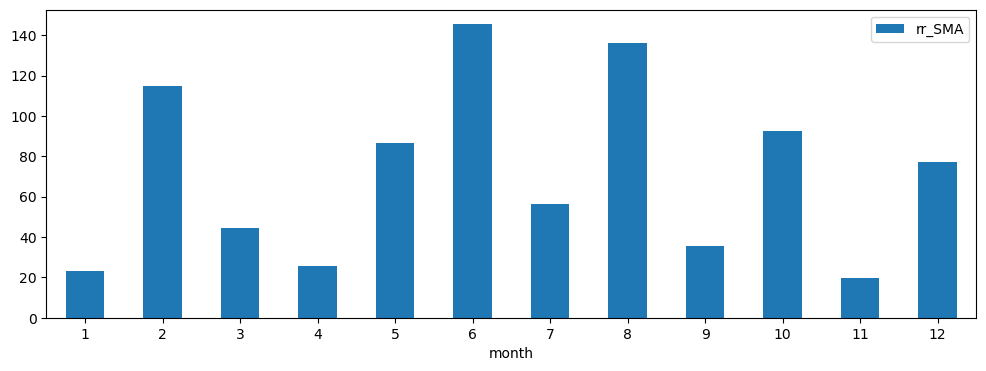

In [147]:
df_for_chart = rr_df_from_csv # rr_df_from_csv,  ss_df_from_csv, dd_df_from_csv, ff_df_from_csv
year_for_chart = 2020 # 2019, 2020, 2021, 2022

df_for_chart = df_for_chart.iloc[:,[0,1,2]].loc[df_for_chart.year==year_for_chart]

fig, axs = plt.subplots(figsize=(12, 4))
df_for_chart.iloc[:,[1]].groupby(df_for_chart["DateTime"].dt.month).sum().plot(
    kind='bar', rot=0, ax=axs,
    xlabel = 'month'
)

### <b style="color:blue;"> Prepare data for model and streaming </b>

In [156]:
start_date = '2019-07-01 00:00:00'
split_date = '2022-11-01 00:00:00'
end_date = '2022-11-30 23:59:59'
#model_df = pd.DataFrame([])
#stream_df = pd.DataFrame([])
i = 0

for df in [rr_df_from_csv, ss_df_from_csv, dd_df_from_csv, ff_df_from_csv]:
    if i == 0:
        model_df = df.iloc[:,[0,1]].loc[df['DateTime'] < split_date]
        model_df = model_df.loc[model_df['DateTime'] >= start_date]
        stream_df = df.iloc[:,[0,1]].loc[df['DateTime'] >= split_date]
        stream_df = stream_df.loc[stream_df['DateTime'] < end_date]
        i+=1
    else:
        new_model_df = df.iloc[:,[0,1]].loc[df['DateTime'] < split_date]
        new_model_df = new_model_df.loc[new_model_df['DateTime'] >= start_date]   
        new_stream_df = df.iloc[:,[0,1]].loc[df['DateTime'] >= split_date]
        new_stream_df = new_stream_df.loc[new_stream_df['DateTime'] < end_date]
        model_df = model_df.merge(new_model_df, on = "DateTime")
        stream_df = stream_df.merge(new_stream_df, on = "DateTime")       

In [159]:
model_df.to_csv("weather_data_for_modelling.csv", index=True)
stream_df.to_csv("weather_data_for_streaming.csv", index=True)